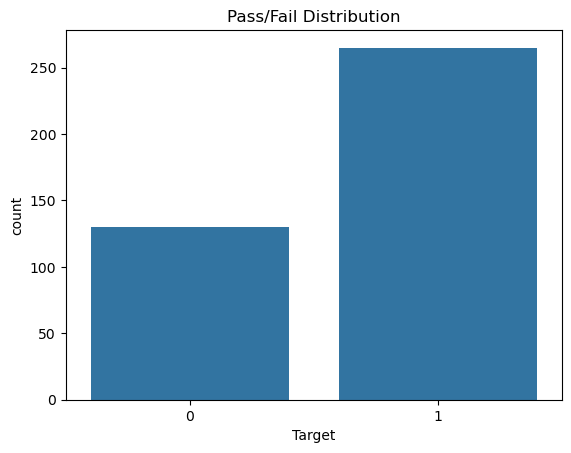

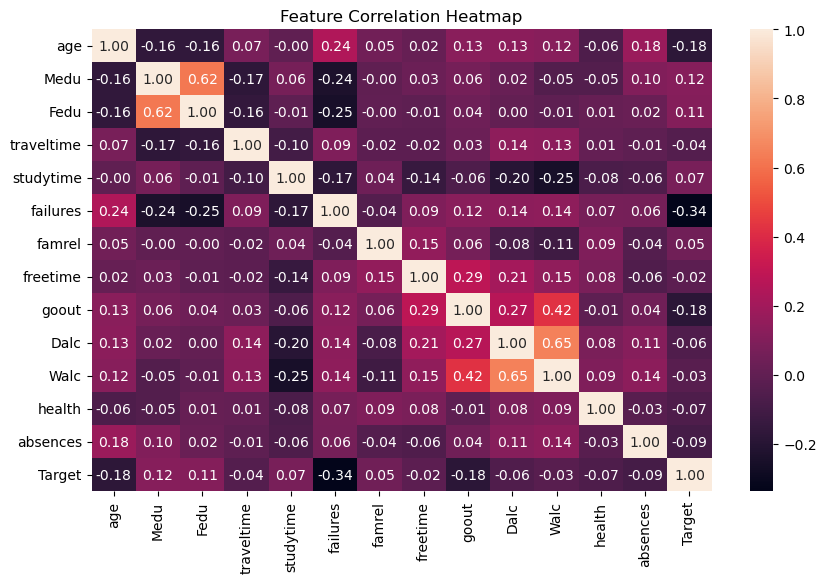

Accuracy: 0.7166666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.37      0.45        19
           1       0.75      0.88      0.81        41

    accuracy                           0.72        60
   macro avg       0.67      0.62      0.63        60
weighted avg       0.70      0.72      0.70        60



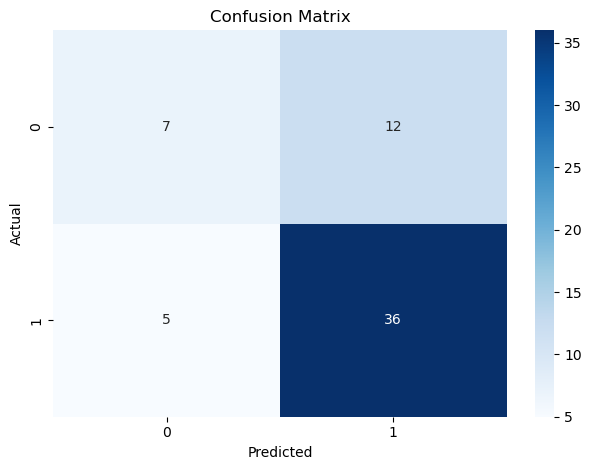

Model saved as student_model.pkl


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Load dataset
df = pd.read_csv("student-mat.csv", sep=';')

# Binary target: 1 if G3 >= 10 else 0
df["Target"] = (df["G3"] >= 10).astype(int)

# Drop G1, G2, G3 to prevent data leakage
df.drop(columns=["G1", "G2", "G3"], inplace=True)

# Drop missing values
df.dropna(inplace=True)

# Visualize class distribution
sns.countplot(x="Target", data=df)
plt.title("Pass/Fail Distribution")
plt.show()

# Correlation heatmap (only numerics)
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Feature/target split
X = df.drop("Target", axis=1)
y = df["Target"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Save model
joblib.dump((model, scaler, X.columns), "student_model.pkl")
print("Model saved as student_model.pkl")

In [2]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Page setup
st.set_page_config(page_title="Student Performance App", layout="wide")

# Load data
raw_df = pd.read_csv("student-mat.csv", sep=';')

# Load model
model, scaler, feature_names = joblib.load("student_model.pkl")
# Compute model accuracy for sidebar display
# Reprocess training data (same as in training script)
df = raw_df.copy()
df["Target"] = (df["G3"] >= 10).astype(int)
df.drop(columns=["G1", "G2", "G3"], inplace=True)
df = pd.get_dummies(df, drop_first=True)
X = df.drop("Target", axis=1)
y = df["Target"]

# Align features to match training model
for col in feature_names:
    if col not in X.columns:
        X[col] = 0
X = X[feature_names]

from sklearn.metrics import accuracy_score
X_scaled = scaler.transform(X)
y_pred = model.predict(X_scaled)
model_accuracy = accuracy_score(y, y_pred)


# Sidebar Navigation
st.sidebar.title("📚 Navigation")
page = st.sidebar.radio("Go to", ["📄 View Raw Data", "🧹 Cleaned Data & Correlation", "🎯 Prediction"])
st.sidebar.markdown(f"**📈 Model Accuracy:** `{model_accuracy:.2%}`")

# ============================
# PAGE 1: View Raw Data
# ============================
if page == "📄 View Raw Data":
    st.title("📄 Raw Student Data")
    st.write("This is the original unprocessed dataset from the UCI repository.")
    st.dataframe(raw_df)

# ============================
# PAGE 2: Cleaned Data & Correlation
# ============================
elif page == "🧹 Cleaned Data & Correlation":
    st.title("🧹 Cleaned Data & Feature Correlation")

    # Preprocessing same as training
    df = raw_df.copy()
    df["Target"] = (df["G3"] >= 10).astype(int)
    df.drop(columns=["G1", "G2", "G3"], inplace=True)
    df.dropna(inplace=True)
    df = pd.get_dummies(df, drop_first=True)

    st.subheader("Cleaned Data Sample")
    st.dataframe(df.head())

    st.subheader("📊 Correlation Heatmap")
    plt.figure(figsize=(12, 8))
    corr = df.corr()
    sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")
    st.pyplot(plt)

# ============================
# PAGE 3: Student Prediction
# ============================
elif page == "🎯 Prediction":
    st.title("🎯 Student Performance Predictor")
    st.write("Enter the student's details to predict whether they are likely to pass.")

    # Basic user inputs
    age = st.slider("Age", 15, 22, 17)
    studytime = st.selectbox("Study Time (1: <2h, 4: >10h)", [1, 2, 3, 4])
    failures = st.selectbox("Number of Past Failures", [0, 1, 2, 3])
    absences = st.slider("Absences", 0, 93, 5)
    schoolsup = st.selectbox("Extra Educational Support?", ['yes', 'no'])

    input_dict = {
        "age": age,
        "studytime": studytime,
        "failures": failures,
        "absences": absences,
        "schoolsup_yes": 1 if schoolsup == 'yes' else 0,
    }

    input_df = pd.DataFrame([input_dict])
    for col in feature_names:
        if col not in input_df.columns:
            input_df[col] = 0
    input_df = input_df[feature_names]

    input_scaled = scaler.transform(input_df)

    if st.button("Predict"):
        pred = model.predict(input_scaled)[0]
        prob = model.predict_proba(input_scaled)[0][pred]
        if pred == 1:
            st.success(f"✅ The student is likely to PASS! (Confidence: {prob:.2%})")
        else:
            st.error(f"❌ The student is likely to FAIL. (Confidence: {prob:.2%})")


Overwriting app.py


In [ ]:
!streamlit run app.py